<a href="https://colab.research.google.com/github/pepborrell/LauzHack2019/blob/master/PredictComment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Concatenate, SimpleRNN
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.preprocessing.sequence as sequence
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

# Predicting the comment
From an image, we want to predict a comment.

## Loading the data

In [4]:
#url = 'https://pastebin.com/raw/SjMqw5Wx'
# url = 'https://pastebin.com/raw/Kbr3apyg'
# url = 'https://pastebin.com/raw/r2E7KsWP'
url = 'https://pastebin.com/raw/LDU9XZpU'
df = pd.read_csv(url)

df.head()

,id,postid,url,upvotes,top comment
0,0,dpoppg,https://i.redd.it/v91swki75wv31.jpg,125639,['Ah\\ yes\\ the\\ I\\̓\\̉\\̓\\̆\\͗\\̭\\͇\\͙\\...
1,1,dikhsj,https://i.redd.it/osr5o5ox5us31.jpg,105442,"['As\\ an\\ Italian\\,\\ I\\ 100\\%\\ relate',..."
2,2,ds0ttz,https://i.redd.it/p9a9mskj0ww31.jpg,65,"['That\\'s\\ my\\ master\\ plan', 'OP\\ really..."
3,3,dgcuf8,https://i.redd.it/flsim843wvr31.jpg,138513,['What\\'s\\ the\\ difference\\ between\\ 1\\ ...
4,4,dplvla,https://i.redd.it/4j8thq1lyuv31.jpg,35836,"['F', '\\⠀\\⠀\\⢀\\⡤\\⢶\\⣶\\⣶\\⡄\\⠀\\⠀\\⠀\\⠀\\⠀..."


## Extracting information from image
We use a VGG16 model pretrained with ImageNet data. We don't use the last softmax layer, but reuse the other ones.

In [5]:
modelvgg = VGG16(include_top=True,weights='imagenet')

modelvgg.layers.pop()
modelvgg = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)

modelvgg.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 33s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

## Extracting data from each image

In [6]:
import urllib
from io import BytesIO
import requests

npix = 224
target_size = (npix,npix,3)

images = {}
for idx, row in df.iterrows():
    print(idx)
    postid = row['postid']
    imageUrl = row['url']
    # postid, imageUrl = row['postid'], row['imageUrl']
    # print(idx)
    try:
        with urllib.request.urlopen(imageUrl) as url:
            img = image.load_img(BytesIO(url.read()), target_size=target_size)
    except:
        continue
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    nimage = preprocess_input(x)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[postid] = y_pred.flatten()
    print('ok')

0
ok
1
ok
2
ok
3
4
ok
5
ok
6
ok
7
ok
8
ok
9
ok
10
ok
11
ok
12
ok
13
ok
14
ok
15
ok
16
ok
17
18
ok
19
ok
20
ok
21
ok
22
ok
23
ok
24
ok
25
ok
26
ok
27
ok
28
ok
29
ok
30
ok
31
ok
32
ok
33
ok
34
ok
35
ok
36
ok
37
ok
38
ok
39
ok
40
ok
41
ok
42
ok
43
ok
44
ok
45
ok
46
ok
47
ok
48
ok
49
ok
50
ok
51
ok
52
ok
53
ok
54
ok
55
ok
56
ok
57
ok
58
ok
59
ok
60
ok
61
ok
62
ok
63
ok
64
ok
65
ok
66
ok
67
ok
68
ok
69
ok
70
ok
71
ok
72
ok
73
ok
74
ok
75
ok
76
ok
77
ok
78
ok
79
ok
80
ok
81
ok
82
ok
83
ok
84
ok
85
ok
86
ok
87
ok
88
ok
89
ok
90
ok
91
ok
92
ok
93
ok
94
ok
95
ok
96
ok
97
ok
98
ok
99
ok
100
ok
101
ok
102
ok
103
ok
104
ok
105
ok
106
ok
107
ok
108
ok
109
ok
110
ok
111
ok
112
ok
113
ok
114
ok
115
ok
116
ok
117
ok
118
ok
119
ok
120
ok
121
ok
122
ok
123
ok
124
ok
125
ok
126
ok
127
ok
128
ok
129
ok
130
ok
131
ok
132
ok
133
ok
134
ok
135
ok
136
ok
137
ok
138
ok
139
ok
140
ok
141
ok
142
ok
143
ok
144
ok
145
ok
146
ok
147
ok
148
ok
149
ok
150
ok
151
ok
152
ok
153
ok
154
ok
155
ok
156
ok
157
ok
158
ok
159

In [0]:
import pickle
with open('images.pik', 'wb') as f:
    pickle.dump(images, f)

In [0]:
# Reading a file with the image metadata
import pickle
with open('images.pik', 'rb') as f:
    images = pickle.load(f)

## Text cleaning and preprocessing


In [8]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
st_words = set(stopwords.words('english'))

def cleanWords(text):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # Convert to lowercase
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [word.translate(table) for word in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1 or word in ['i', 'u']]
    # remove tokens with numbers in them
    text = [word for word in text if not word.isnumeric()]
    # remove stopwords
    # text = [word for word in text if not word in st_words]
    # remove forbidden words
    forbidden_words = ['doot']
    text = [word for word in text if word not in forbidden_words]
    return text

def cleanComment(text):
    text = text.split(' ')
    text = cleanWords(text)
    return text

def addStartEndSeq(words):
    return ['startseq'] + words + ['endseq']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
df['clean_comment'] = df.apply(lambda x : cleanComment(x['top comment']), axis=1)

df['clean_comment'] = df.apply(lambda x : addStartEndSeq(x['clean_comment']), axis=1)

max_comment_length = max(len(x) for x in df['clean_comment'])

df_copy = df
df = df[df['clean_comment'].apply(lambda x : len(x) >= 5)]

all_text = []
for text in df['clean_comment']:
    all_text += text

from collections import Counter
counter = Counter(all_text)
word_freq = list(counter.items())
word_freq.sort(key = (lambda x : -x[1]))
word_freq = ['PAD'] + word_freq

# To check where are word frequencies change
# for idx, elem in enumerate(word_freq):
#     if elem[1] == 2:
#         print(idx)
#         break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([  0.,   0.,  39.,  97., 119.,  80.,  66.,  38.,  32.,  28.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

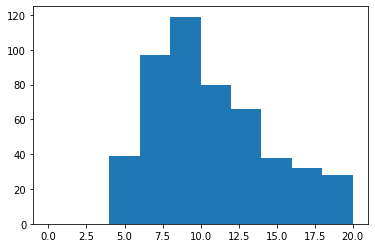

In [207]:
import matplotlib.pyplot as plt
sizes = [len(x) for x in df['clean_comment']]
plt.hist(sizes, range=(0,20))

In [11]:
print(word_freq)

['PAD', ('the', 661), ('startseq', 480), ('endseq', 480), ('i', 391), ('to', 346), ('you', 315), ('and', 310), ('that', 271), ('is', 270), ('of', 254), ('it', 241), ('in', 147), ('not', 136), ('for', 136), ('this', 127), ('but', 120), ('just', 117), ('are', 114), ('my', 113), ('on', 111), ('with', 106), ('have', 104), ('they', 102), ('its', 99), ('was', 99), ('like', 94), ('so', 92), ('what', 90), ('if', 90), ('no', 90), ('me', 80), ('your', 79), ('be', 72), ('can', 71), ('we', 68), ('do', 68), ('or', 67), ('im', 61), ('one', 60), ('he', 60), ('all', 60), ('people', 59), ('about', 57), ('as', 56), ('more', 54), ('at', 53), ('when', 52), ('because', 51), ('dont', 50), ('from', 48), ('only', 47), ('know', 47), ('think', 47), ('would', 45), ('who', 44), ('how', 44), ('up', 42), ('then', 41), ('ok', 40), ('an', 39), ('get', 39), ('say', 38), ('even', 38), ('thats', 37), ('good', 37), ('out', 37), ('here', 37), ('were', 37), ('will', 37), ('now', 35), ('than', 34), ('there', 33), ('their', 

## Creating the word encoding
We assign a number to each word, and encode them using these numbers. In this way, the sentences will now be of the form [1,4,2,6,2,...] (padded to match the needed size)

In [0]:
vocab_size = 1024

word_to_idx = {}
idx_to_word = {}
for idx, elem in enumerate(word_freq[:vocab_size]):
    word_to_idx[elem[0]] = idx
    idx_to_word[idx] = elem[0]

In [13]:
def encodeComment(words):
    # encoding = np.zeros(max_comment_length, dtype=int)
    encoding = [word_to_idx[word] for word in words if word in word_to_idx]
    encoding = np.asarray(encoding)
    # encoding = sequence.pad_sequences([encoding], maxlen=max_comment_length, padding='post')
    encoding = np.reshape(encoding, (len(encoding),))
    # encoding = to_categorical(encoding,num_classes = vocab_size)
    return encoding

df['encoded_comment'] = df.apply(lambda x : encodeComment(x['clean_comment']), axis=1)
df.head()

,id,postid,url,upvotes,top comment,clean_comment,encoded_comment
0,0,dpoppg,https://i.redd.it/v91swki75wv31.jpg,125639,['Ah\\ yes\\ the\\ I\\̓\\̉\\̓\\̆\\͗\\̭\\͇\\͙\\...,"[startseq, ah, yes, the, i̭͇͙̘̤̗̹̣̞̙̝͖̗̮̮̓̉̓̆͗...","[2, 397, 92, 1, 28, 339, 3]"
1,1,dikhsj,https://i.redd.it/osr5o5ox5us31.jpg,105442,"['As\\ an\\ Italian\\,\\ I\\ 100\\%\\ relate',...","[startseq, as, an, italian, i, relate, thats, ...","[2, 44, 60, 622, 4, 623, 64, 13, 64, 19, 398, ..."
2,2,ds0ttz,https://i.redd.it/p9a9mskj0ww31.jpg,65,"['That\\'s\\ my\\ master\\ plan', 'OP\\ really...","[startseq, thats, my, master, plan, op, really...","[2, 64, 19, 862, 863, 493, 84, 624, 109, 1, 18..."
3,3,dgcuf8,https://i.redd.it/flsim843wvr31.jpg,138513,['What\\'s\\ the\\ difference\\ between\\ 1\\ ...,"[startseq, whats, the, difference, between, an...","[2, 243, 1, 269, 244, 7, 303, 865, 625, 494, 7..."
4,4,dplvla,https://i.redd.it/4j8thq1lyuv31.jpg,35836,"['F', '\\⠀\\⠀\\⢀\\⡤\\⢶\\⣶\\⣶\\⡄\\⠀\\⠀\\⠀\\⠀\\⠀...","[startseq, ⠀⠀⢀⡤⢶⣶⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀, nn⠀⠀⢀⣠⣤⣤⣤⣿⣧⣀⣀⣀...","[2, 3]"


## Preparing the inputs
Now that everything is well filtered we can prepare the input for the neural network

In [0]:
def splitData(data, data_size):
    train_division = int(0.6*data_size)
    test_division = int(0.8*data_size)

    data_train = data[0:train_division]
    data_test = data[train_division+1:test_division]
    data_val = data[test_division+1:]
    return data_train, data_test, data_val

df_size = df.shape[0]  # gives number of row count
[df_train, df_test, df_val] = splitData(df, df_size)

In [0]:
def preprocessing(df, images):
    Xtext, Ximage, ytext = [],[],[]
    for idx, row in df.iterrows():
        if row['postid'] in images:
            text = row['encoded_comment']
            for i in range(1, len(text)):
                in_text, out_text = text[:i], text[i]
                in_text = sequence.pad_sequences([in_text],maxlen=max_comment_length, padding='post').flatten()
                out_text = to_categorical(out_text,num_classes = vocab_size)
                                        
                Xtext.append(in_text)
                Ximage.append(images[row['postid']])
                ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)

    return (Xtext,Ximage,ytext)

## Defining the model
We will use the Keras functional API. We will define a model that recieves the comments and passes them through Embedding and LSTM layers, and also recieves the information from the images and channels it all through some dense layers.

In [0]:
# hyperparameters
embedding_dim = 256
vgg_output_size = 4096


In [0]:
# image feature extractor model
inputs1 = Input(shape=(vgg_output_size,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_comment_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se3 = Dropout(0.5)(se3)
se3, state_h, state_c = LSTM(256, return_state=True)(se3)
encoder_states = [state_h, state_c]


# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
# decoder1 = Embedding(vocab_size, embedding_dim)(decoder1)
# decoder1 = LSTM(256)(decoder1)
# decoder1 = Concatenate()([fe2, se3])
# decoder1 = se3
decoder2 = Dense(256, activation='relu')(decoder1)
decoder2 = Dense(256, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
[xtext_train, ximage_train, ytrain] = preprocessing(df_train, images)
[xtext_test, ximage_test, ytest] = preprocessing(df_test, images)
[xtext_val, ximage_val, yval] = preprocessing(df_val, images)

In [247]:
model.fit([ximage_train, xtext_train], ytrain, epochs=1, batch_size=128)

ValueError: ignored

In [0]:
model.save('model.h5')

# Another model
Let's try

In [23]:
# MODEL FOR ENCODER AND DECODER -------------------------------------------
num_encoder_tokens = embedding_dim = 128
latent_dim = 64 # to avoid "kernel run out of time" situation. I used 256.

# encoder training
# encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder_inputs = Input(shape=(max_comment_length,))
encoder_inputs = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, 
               batch_input_shape = (1, None, num_encoder_tokens),
               stateful = False,
               return_sequences = True,
               return_state = True,
               recurrent_initializer = 'glorot_uniform')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c] # 'encoder_outputs' are ignored and only states are kept.

# Decoder training, using 'encoder_states' as initial state.
decoder_inputs = Input(shape=(None, num_encoder_tokens))

decoder_lstm_1 = LSTM(latent_dim,
                      batch_input_shape = (1, None, num_encoder_tokens),
                      stateful = False,
                      return_sequences = True,
                      return_state = False,
                      dropout = 0.2,
                      recurrent_dropout = 0.2) # True

decoder_lstm_2 = LSTM(32, # to avoid "kernel run out of time" situation. I used 128.
                     stateful = False,
                     return_sequences = True,
                     return_state = True,
                     dropout = 0.2,
                     recurrent_dropout = 0.2)

decoder_outputs, _, _ = decoder_lstm_2(decoder_lstm_1(decoder_inputs, initial_state = encoder_states))
decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
decoder_outputs = decoder_dense(decoder_outputs)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


NameError: ignored

In [0]:

# training model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Predicting photo captions with the model
A so-called 'greedy-search' algorithm feeds the picture and a start sequence to the network. It then takes the output word and feeds it along with the picture to the net again. This goes on until the word limit is achieved or an end sequence is received.

In [0]:
import time

def inverseFreq(word_freq):
    output = []
    for elem in word_freq:
        if elem != 'PAD':
            output.append(1/elem[1])
        else:
            output.append(0)
    return np.array(output)

def greedySearch(photo):
    np.random.seed(int(time.time()))
    # in_text = idx_to_word[np.random.randint(1, 100, 1)[0]]
    in_text = 'startseq'
    comment_length = 25
    # for i in range(max_comment_length):
    for i in range(comment_length):
        seq = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        seq = sequence.pad_sequences([seq], maxlen=max_comment_length, padding='post')
        yhat = model.predict([photo, seq])
        yhat[0][word_to_idx['endseq']] -= 0.05*max(20-i, 0)
        # yhat[0][word_to_idx[in_text.split()[-1]]] -= 1
        # yhat = yhat*inverseFreq(word_freq[:vocab_size])*1.3

        for idx, word in enumerate(in_text.split(' ')):
            yhat[0][word_to_idx[word]] -= max(0.3 - idx*0.01, 0)
        
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    # final = final[1:-1]
    final = ' '.join(final)
    return final

In [243]:
output = greedySearch(np.array([ximage_test[100]]))
print(output)

startseq the i to it you and is in of for are this that know they not just but my with endseq


In [221]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 397)]        0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 397, 16)      16384       input_58[0][0]                   
__________________________________________________________________________________________________
dropout_65 (Dropout)            (None, 397, 16)      0           embedding_37[0][0]               
__________________________________________________________________________________________________
lstm_43 (LSTM)                  (None, 397, 256)     279552      dropout_65[0][0]                 
___________________________________________________________________________________________